In [1]:
from abc import ABC, abstractmethod
from typing import Optional
import collections as cs
import enum as en
import numpy as np
import itertools as it
import more_itertools as mit
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import os
import sympy as sp
import scipy as sci
import operator as op
import random

In [2]:
from libs.environment.utils import *
from libs.utils.graph import *
from libs.environment.cost.tsp import *
from libs.solution.initial_solution_generators.heuristic import *
from libs.solution.initial_solution_generators.random import *
from libs.optimizers.algorithms.genetic.operators.mutations import *
from libs.optimizers.algorithms.genetic.operators.crossovers import *

<AxesSubplot:xlabel='x', ylabel='y'>

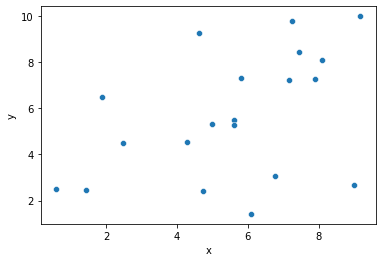

In [3]:
coords = coords_random(20, max_x=10, max_y=10)
sns.scatterplot(x=coords.x, y=coords.y)

<AxesSubplot:>

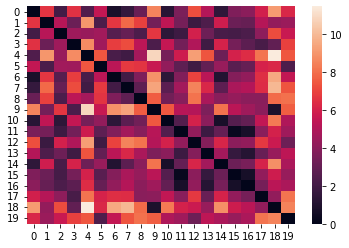

In [4]:
distances = coords_distances(coords, std_dev=0.1)
sns.heatmap(distances)

<class 'numpy.ndarray'>


<AxesSubplot:>

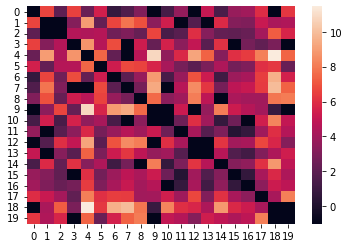

In [5]:
print(type(distances))
np.array(distances)
permitted_distances = disable_edges(distances, prohibition_p=0.1)
sns.heatmap(permitted_distances)

<AxesSubplot:>

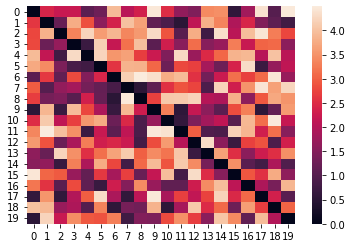

In [6]:
wind = wind_random(permitted_distances, max_velocity=2)
speed = 2.5
eff_speed = effective_speed(speed, wind)
sns.heatmap(eff_speed)

<AxesSubplot:>

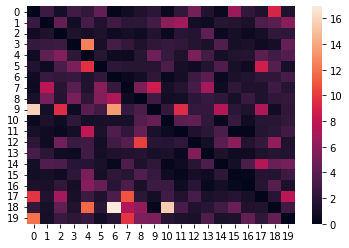

In [7]:
travel_t = travel_times(distances, eff_speed)
sns.heatmap(travel_t)

In [8]:
environment = EnvironmentTSPSimple(travel_t)

In [9]:
solution_creator = SolutionCreatorTSPSimpleHeuristicNN()
greedy_solution = solution_creator.create(environment, initial_vx=0)
greedy_solution

SolutionRepresentationTSP(representation=[0, 6, 10, 14, 11, 15, 16, 13, 3, 17, 9, 18, 1, 12, 5, 19, 4, 7, 2, 8])

In [10]:
vxs = list(range(coords.shape[0]))
print(
    f"{len(greedy_solution.representation) = }, success: {set(greedy_solution.representation) == set(vxs)}"
)

len(greedy_solution.representation) = 20, success: True


In [11]:
cost_calculator = TSPCostCalculatorSimple()
total_cost, step_cost = cost_calculator.calculate_total(greedy_solution, environment)
total_cost, step_cost

(14.569404867309652,
 deque([0.19428284535613294,
        0.35720512450129954,
        0.34786680494235256,
        0.7260395646082837,
        0.056111620463563223,
        0.23885059954559384,
        0.33336743691695403,
        0.5456782596466137,
        0.7110677533563738,
        0.908546941060069,
        0.7485170943931024,
        1.0895087244189319,
        0.8239522945163261,
        0.8337612223903117,
        1.1035940295878381,
        2.5280707765238644,
        0.5392647585409446,
        1.8361122733235113,
        0.647606743217585]))

In [12]:
for i, cost in enumerate(cost_calculator.stepper(greedy_solution, environment)):
    print(f"{i = }, {cost = }")

i = 0, cost = 0.19428284535613294
i = 1, cost = 0.35720512450129954
i = 2, cost = 0.34786680494235256
i = 3, cost = 0.7260395646082837
i = 4, cost = 0.056111620463563223
i = 5, cost = 0.23885059954559384
i = 6, cost = 0.33336743691695403
i = 7, cost = 0.5456782596466137
i = 8, cost = 0.7110677533563738
i = 9, cost = 0.908546941060069
i = 10, cost = 0.7485170943931024
i = 11, cost = 1.0895087244189319
i = 12, cost = 0.8239522945163261
i = 13, cost = 0.8337612223903117
i = 14, cost = 1.1035940295878381
i = 15, cost = 2.5280707765238644
i = 16, cost = 0.5392647585409446
i = 17, cost = 1.8361122733235113
i = 18, cost = 0.647606743217585


In [13]:
rnd_sol_creator = SolutionCreatorTSPSimpleRandom()
rnd_sol = rnd_sol_creator.create(environment, initial_vx=0)
print(
    f"{len(rnd_sol.representation) = }, success: {set(rnd_sol.representation) == set(vxs)}"
)

len(rnd_sol.representation) = 20, success: True


In [14]:
mutator_swap = MutatorHomogenousVectorSwap()
mutator_shuffle = MutatorHomogenousVectorShuffle()
chromosome = ChromosomeHomogenousVector(greedy_solution.representation)

In [15]:
mutated = mutator_swap.mutate(chromosome, lam=4)
print(f"{chromosome.vertex_sequence = }\n{mutated.vertex_sequence    = }")

chromosome.vertex_sequence = [0, 6, 10, 14, 11, 15, 16, 13, 3, 17, 9, 18, 1, 12, 5, 19, 4, 7, 2, 8]
mutated.vertex_sequence    = [9, 6, 10, 14, 11, 19, 16, 13, 3, 0, 4, 18, 1, 12, 5, 15, 17, 2, 7, 8]


In [16]:
mutated = mutator_shuffle.mutate(chromosome, lam=5, probability=1)
print(f"{chromosome.vertex_sequence = }\n{mutated.vertex_sequence    = }")

chromosome.vertex_sequence = [0, 6, 10, 14, 11, 15, 16, 13, 3, 17, 9, 18, 1, 12, 5, 19, 4, 7, 2, 8]
mutated.vertex_sequence    = [13, 3, 17, 2, 8, 1, 12, 0, 6, 10, 14, 5, 19, 4, 7, 11, 15, 16, 9, 18]


In [17]:
print(f"success: {set(chromosome.vertex_sequence) == set(mutated.vertex_sequence)}")

success: True


In [18]:
crossover_normal = CrossoverHomogenousVector()
crossover_kpoint = CrossoverHomogenousVectorKPoint()

In [19]:
chromosome1 = ChromosomeHomogenousVector(greedy_solution.representation)
chromosome2 = ChromosomeHomogenousVector(rnd_sol.representation)

In [20]:
new_generation_normal = crossover_normal.execute(chromosome1, chromosome2)
new_generation_kpoint = crossover_kpoint.execute(chromosome1, chromosome2, k=3)

loci = [1, 13, 16]
vx1_chunks = [[0], [6, 10, 14, 11, 15, 16, 13, 3, 17, 9, 18, 1], [12, 5, 19], [4, 7, 2, 8]]
vx2_chunks = [[0], [14, 4, 6, 19, 3, 1, 13, 5, 11, 2, 18, 9], [16, 10, 8], [7, 15, 17, 12]]
new vx1 chunks: [[0], [14, 4, 6, 19, 3, 1, 13, 5, 11, 2, 18, 9], [12, 5, 19], [7, 15, 17, 12]]
new vx2 chunks: [[0], [6, 10, 14, 11, 15, 16, 13, 3, 17, 9, 18, 1], [16, 10, 8], [4, 7, 2, 8]]


In [22]:
print(
    f"parents:\n\t{chromosome1.vertex_sequence} (len: {len(chromosome1.vertex_sequence)})\n\t{chromosome2.vertex_sequence} (len: {len(chromosome2.vertex_sequence)})"
)
print(
    f"normal:\n\t{new_generation_normal[0].vertex_sequence} (len: {len(new_generation_normal[0].vertex_sequence)})\n\t{new_generation_normal[1].vertex_sequence} (len: {len(new_generation_normal[1].vertex_sequence)})"
)
print(
    f"k-point:\n\t{new_generation_kpoint[0].vertex_sequence} (len: {len(new_generation_kpoint[0].vertex_sequence)})\n\t{new_generation_kpoint[1].vertex_sequence} (len: {len(new_generation_kpoint[1].vertex_sequence)})"
)

parents:
	[0, 6, 10, 14, 11, 15, 16, 13, 3, 17, 9, 18, 1, 12, 5, 19, 4, 7, 2, 8] (len: 20)
	[0, 14, 4, 6, 19, 3, 1, 13, 5, 11, 2, 18, 9, 16, 10, 8, 7, 15, 17, 12] (len: 20)
normal:
	[5, 19, 4, 7, 2, 8, 0, 14, 4, 6, 19, 3, 1, 13, 5, 11, 2, 18, 9, 16] (len: 20)
	[10, 8, 7, 15, 17, 12, 0, 6, 10, 14, 11, 15, 16, 13, 3, 17, 9, 18, 1, 12] (len: 20)
k-point:
	[0, 14, 4, 6, 19, 3, 1, 13, 5, 11, 2, 18, 9, 12, 5, 19, 7, 15, 17, 12] (len: 20)
	[0, 6, 10, 14, 11, 15, 16, 13, 3, 17, 9, 18, 1, 16, 10, 8, 4, 7, 2, 8] (len: 20)


Note - Crossover is useless for TSP and other problems, where values can not repeat themselves.